In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the model using the `CarveMix` technique.

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from semantic_segmentation_augmentations.holemakertechnique import HoleMakerROI
from semantic_segmentation_augmentations.holesfilling import CarveMix

from vision_models_evaluation.core import evaluate

from sklearn.model_selection import KFold

import pandas as pd

import matplotlib.pyplot as plt

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch; torch.cuda.set_device(1)

Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn(x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        if len(x) == 2:
            img, mask = x
        elif len(x) == 1:
            img = x[0]
            mask = np.zeros_like(img)

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask
    
def decodes(mask):
    shape = mask.shape
    _mask = np.empty([*shape, 3])
    grape_c = np.array([255, 255, 255])
    leaves_c = np.array([0, 255, 0])
    pole_c = np.array([255, 0, 0])
    wood_c = np.array([0, 0, 255])
    back_c = np.array([0, 0, 0])
    
    for j in range(shape[0]):
        for i in range(shape[1]):
            if mask[j, i] == 1:
                _mask[j, i] = grape_c
            elif mask[j, i] == 2:
                _mask[j, i] = leaves_c
            elif mask[j, i] == 3:
                _mask[j, i] = pole_c
            elif mask[j, i] == 4:
                _mask[j, i] = wood_c
            else:
                _mask[j, i] = back_c
    
    return _mask.astype(np.uint8)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [ ]:
esc = EarlyStoppingCallback(patience = 5, min_delta = 0.01)

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [ ]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": []
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

saving_hparams = {
    "save_best": True,
    "metric": "DiceMulti",
    "model_name": "CarveMix"
}

In order to know how does this technique work, we can show an example.

This technique cuts a region of interesi (ROI) from an image (a region that contains a group of pixels of a class) and put them into another image.

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


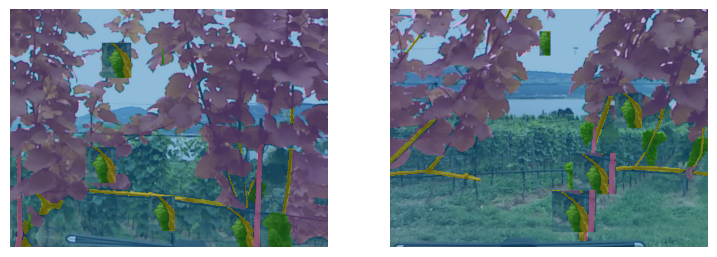

In [ ]:
cv = CarveMix(holes_num = 10, ROI_class = 1, delta_ratio = None, random_position = True, p = 1)
dls = DataBlock(**db_hparams).dataloaders(**dls_hparams)
with Learner(dls, resnet50(), metrics=[DiceMulti()], cbs = cv) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(1, 2, figsize=(9, 9))
dls.show_batch(b = (cv.x, cv.y), ctxs = axs.flatten())

Finally, we test the model with distinct hparams.

In [ ]:
results = {}

for holes_num in [1, 3, 5]:
    for ROI_class in [1, -1]:
        for position in [True, False]:
            cm = CarveMix(holes_num, None, ROI_class, position)
            learner_hparams["cbs"] = [esc, cm]
            r = evaluate(db_hparams,
                         dls_hparams,
                         technique,
                         learner_hparams,
                         learning_hparams,
                         learning_mode,
                         saving_hparams,
                         verbose = True
                        )
            results.update({
                str(holes_num) + str(ROI_class) + str(position): r["DiceMulti"]
            })

Starting the training for a new model
Training the fold 1


/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,dice_multi,time
0,1.113739,0.697297,0.324140,00:21
1,0.782923,0.795281,0.322940,00:19
2,0.622660,0.465299,0.402891,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.395428,0.328868,0.512775,00:19
1,0.371415,0.301610,0.626952,00:20
2,0.343954,0.285360,0.707001,00:19
3,0.332193,0.332701,0.751463,00:19
4,0.325571,0.251006,0.793729,00:19
5,0.312872,0.244227,0.810052,00:19
6,0.305760,0.279742,0.789108,00:19
7,0.299051,0.269287,0.741778,00:20
8,0.295793,0.286339,0.765903,00:19
9,0.290737,0.274687,0.804361,00:19


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2675047218799591  /  DiceMulti: 0.8170860250659112  
Saving best model because DiceMulti 0.8171 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.867418,0.696691,0.347584,00:19
1,0.662439,0.429687,0.352579,00:19
2,0.573098,0.683995,0.323765,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.413878,0.399124,0.584247,00:20
1,0.376514,0.306180,0.722845,00:20
2,0.343811,0.353719,0.586963,00:20
3,0.343970,0.372587,0.726258,00:20
4,0.332788,0.293133,0.731382,00:20
5,0.324349,0.272240,0.752960,00:20
6,0.309406,0.330725,0.796940,00:20
7,0.308142,0.279139,0.798788,00:20
8,0.289529,0.279541,0.790997,00:20
9,0.278397,0.275017,0.801033,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.24354787170886993  /  DiceMulti: 0.7870450479202218  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.001033,0.624304,0.324953,00:19
1,0.694771,0.386712,0.396786,00:20
2,0.885522,0.716610,0.266810,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.537283,0.398959,0.355049,00:20
1,0.460351,0.365789,0.445798,00:20
2,0.423492,0.362306,0.504013,00:20
3,0.384342,0.330310,0.661443,00:20
4,0.352997,0.323820,0.702559,00:20
5,0.339354,0.416586,0.626715,00:20
6,0.324976,0.296148,0.766321,00:20
7,0.304941,0.278978,0.780164,00:20
8,0.286960,0.269435,0.793261,00:20
9,0.277799,0.282621,0.772622,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.1649300456047058  /  DiceMulti: 0.8608352824148016  
Saving best model because DiceMulti 0.8608 >= 0.8171.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.841835,0.499555,0.356777,00:19
1,0.712003,0.622347,0.315170,00:20
2,0.649459,0.492341,0.391936,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.453147,0.304052,0.565586,00:20
1,0.421917,0.282500,0.700622,00:20
2,0.386153,0.258673,0.722212,00:20
3,0.364661,0.262966,0.784366,00:21
4,0.343907,0.255091,0.755389,00:21
5,0.338915,0.230797,0.792777,00:20
6,0.324250,0.269656,0.794912,00:20
7,0.313370,0.259615,0.806010,00:20
8,0.303555,0.223511,0.812966,00:20
9,0.293418,0.229849,0.827127,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.24969327449798584  /  DiceMulti: 0.8339743861355379  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.047100,0.538614,0.346536,00:20
1,0.711183,0.656178,0.356485,00:20
2,1.865566,1.290381,0.182041,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.659324,0.512013,0.350433,00:20
1,0.542143,0.484742,0.350658,00:20
2,0.473293,0.406883,0.402879,00:20
3,0.421645,0.364156,0.555758,00:20
4,0.398418,0.372476,0.608857,00:20
5,0.384560,0.404798,0.487905,00:20
6,0.391313,0.336933,0.598747,00:20
7,0.370448,0.345180,0.694078,00:20
8,0.348513,0.295591,0.760138,00:20
9,0.324814,0.289043,0.750913,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.2604750990867615  /  DiceMulti: 0.774955713324436  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.920198,0.904966,0.253876,00:20
1,0.676332,0.852050,0.346046,00:20
2,0.605269,0.591250,0.337629,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.388850,0.468062,0.532214,00:20
1,0.349673,0.446693,0.619071,00:20
2,0.328768,0.423349,0.674889,00:20
3,0.299069,0.568203,0.668674,00:20
4,0.287930,0.441350,0.673342,00:20
5,0.277943,0.447300,0.697816,00:21
6,0.278546,0.404979,0.716749,00:20
7,0.268039,0.428609,0.718798,00:20
8,0.256811,0.383857,0.719862,00:20
9,0.245465,0.423681,0.730211,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.1734641045331955  /  DiceMulti: 0.8727746200467065  
Saving best model because DiceMulti 0.8728 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.873236,0.516989,0.346382,00:20
1,0.750558,1.550673,0.139473,00:20
2,0.792369,0.579482,0.335394,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.490940,0.417454,0.414476,00:20
1,0.456877,0.385423,0.429586,00:20
2,0.414019,0.338734,0.568217,00:20
3,0.395590,0.413152,0.624945,00:20
4,0.367961,0.290605,0.755865,00:20
5,0.345156,0.294880,0.728934,00:20
6,0.335306,0.270034,0.796956,00:20
7,0.336460,0.332631,0.676854,00:20
8,0.321535,0.280914,0.788023,00:20
9,0.299349,0.293311,0.806703,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.1988850235939026  /  DiceMulti: 0.8301518793229723  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.962344,0.629189,0.324276,00:20
1,0.725489,0.590237,0.346966,00:20
2,0.622299,0.401820,0.385105,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.409190,0.348265,0.593885,00:20
1,0.379908,0.352127,0.667433,00:21
2,0.357976,0.302298,0.730795,00:20
3,0.334893,0.291402,0.767199,00:20
4,0.312675,0.309443,0.725587,00:20
5,0.307311,0.333468,0.733978,00:20
6,0.297894,0.297507,0.786038,00:20
7,0.294652,0.287789,0.788252,00:20
8,0.304165,0.336234,0.777680,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.26106950640678406  /  DiceMulti: 0.8189192781418756  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.783511,0.527708,0.351264,00:20
1,0.613723,0.500968,0.453712,00:20
2,0.751828,20.454308,0.138997,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,5.338756,0.488043,0.346370,00:20
1,2.161917,0.350665,0.416490,00:20
2,1.206740,0.370573,0.455560,00:20
3,0.793503,0.274743,0.689776,00:20
4,0.571618,0.263116,0.669962,00:20
5,0.465632,0.289711,0.552954,00:20
6,0.394975,0.246624,0.769621,00:20
7,0.349084,0.246730,0.814826,00:20
8,0.343703,0.259905,0.734983,00:20
9,0.316575,0.259643,0.755738,00:20


No improvement since epoch 18: early stopping


Test results for the model.   validation: 0.16396211087703705  /  DiceMulti: 0.8762167243229669  
Saving best model because DiceMulti 0.8762 >= 0.8728.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.988498,0.639084,0.320283,00:19
1,0.655713,0.429080,0.473760,00:20
2,0.823779,1.724542,0.157794,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.710259,0.519125,0.363058,00:20
1,0.551093,0.433826,0.406059,00:20
2,0.460525,0.368935,0.601808,00:20
3,0.405083,0.352646,0.607796,00:20
4,0.384680,0.332952,0.673868,00:20
5,0.361167,0.352325,0.683690,00:20
6,0.337673,0.305751,0.768911,00:20
7,0.321431,0.280719,0.788862,00:20
8,0.309127,0.273252,0.788118,00:20
9,0.300019,0.304015,0.782647,00:20


No improvement since epoch 17: early stopping


Test results for the model.   validation: 0.20753483474254608  /  DiceMulti: 0.819695565113466  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.902747,0.652719,0.318483,00:20
1,0.671372,0.532777,0.359221,00:20
2,0.590936,0.533851,0.328311,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.396865,0.451455,0.553303,00:20
1,0.356456,0.419849,0.628388,00:20
2,0.317947,0.459930,0.693025,00:20
3,0.295043,0.427417,0.683359,00:20
4,0.293444,0.581704,0.650469,00:20
5,0.289381,0.397362,0.700002,00:21
6,0.269616,0.479247,0.721073,00:20
7,0.267424,0.417001,0.734032,00:21
8,0.264956,0.428315,0.726674,00:20
9,0.250883,0.397416,0.716040,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.20265710353851318  /  DiceMulti: 0.8499719385895361  
Saving best model because DiceMulti 0.85 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.120945,0.859146,0.226099,00:20
1,0.799047,0.463446,0.349733,00:20
2,0.730266,0.714841,0.305322,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.459931,0.427125,0.414959,00:21
1,0.413445,0.344357,0.588273,00:20
2,0.385756,0.362558,0.622102,00:20
3,0.367986,0.351655,0.663568,00:20
4,0.352960,0.301131,0.682089,00:20
5,0.335904,0.302488,0.772156,00:20
6,0.335436,0.311791,0.748002,00:20
7,0.327352,0.302934,0.714737,00:20
8,0.307552,0.286586,0.769390,00:20
9,0.296021,0.264055,0.808282,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.19696995615959167  /  DiceMulti: 0.8294979856731673  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.971007,0.685477,0.332350,00:20
1,0.692808,0.478171,0.347647,00:20
2,0.644971,0.431846,0.459048,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.415034,0.356830,0.579178,00:20
1,0.392965,0.339977,0.693162,00:20
2,0.361546,0.342807,0.686418,00:20
3,0.346024,0.322564,0.762868,00:20
4,0.328388,0.359809,0.704121,00:20
5,0.312369,0.321356,0.750999,00:20
6,0.306560,0.302565,0.782010,00:20
7,0.305877,0.291317,0.753984,00:20
8,0.299567,0.301050,0.779880,00:21
9,0.278007,0.291577,0.795012,00:21


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.15911759436130524  /  DiceMulti: 0.8822092738559422  
Saving best model because DiceMulti 0.8822 >= 0.85.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.985427,0.529089,0.334427,00:20
1,0.736997,0.396661,0.370927,00:20
2,0.616936,0.408417,0.370851,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.423265,0.310692,0.654465,00:20
1,0.388560,0.285606,0.717247,00:20
2,0.368902,0.259891,0.766249,00:20
3,0.347687,0.244961,0.798852,00:21
4,0.334369,0.227136,0.808657,00:20
5,0.333341,0.231472,0.817968,00:20
6,0.320390,0.233686,0.818403,00:20
7,0.312268,0.225513,0.806041,00:20
8,0.311102,0.281626,0.815330,00:20
9,0.303948,0.216256,0.830481,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.18791893124580383  /  DiceMulti: 0.86287119944834  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.968336,0.538800,0.349897,00:20
1,0.693899,0.437328,0.397435,00:20
2,0.653492,0.766975,0.283128,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.443877,0.368020,0.533805,00:21
1,0.379150,0.314448,0.625873,00:20
2,0.352546,0.286981,0.750943,00:21
3,0.332364,0.300297,0.716087,00:21
4,0.320329,0.335974,0.759616,00:20
5,0.314383,0.290415,0.786651,00:20
6,0.302519,0.290339,0.800866,00:20
7,0.297231,0.268505,0.798855,00:20
8,0.287788,0.333161,0.778571,00:20
9,0.276391,0.255354,0.819061,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.24961966276168823  /  DiceMulti: 0.8154123345751779  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.965579,0.905156,0.291641,00:20
1,0.701622,0.507603,0.346177,00:20
2,0.553983,0.597549,0.559138,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.355926,0.477030,0.586700,00:21
1,0.318653,0.447622,0.646626,00:21
2,0.295986,0.409897,0.669408,00:21
3,0.288998,0.418766,0.651420,00:20
4,0.283254,0.599242,0.689611,00:21
5,0.268314,0.395668,0.695685,00:21
6,0.266183,0.361454,0.733740,00:20
7,0.266404,0.449725,0.704911,00:20
8,0.266453,0.435839,0.712210,00:20
9,0.252611,0.551528,0.712993,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.19679448008537292  /  DiceMulti: 0.8461298132833305  
Saving best model because DiceMulti 0.8461 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.848305,0.469782,0.353084,00:20
1,0.756214,0.753879,0.241239,00:21
2,0.662529,0.564803,0.332603,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.431965,0.355833,0.556636,00:21
1,0.386358,0.366838,0.609650,00:21
2,0.377452,0.354282,0.654763,00:21
3,0.352520,0.297071,0.764952,00:21
4,0.332778,0.346795,0.708921,00:21
5,0.322402,0.282256,0.760476,00:21
6,0.310978,0.332650,0.778668,00:21
7,0.315110,0.311968,0.773047,00:21
8,0.314020,0.297087,0.688366,00:20
9,0.307736,0.274776,0.808155,00:21


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.21347728371620178  /  DiceMulti: 0.8435481218076728  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.792551,0.787749,0.334125,00:20
1,0.648253,0.451512,0.350528,00:21
2,0.629404,0.591293,0.335059,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.444313,0.377290,0.464983,00:21
1,0.396899,0.332060,0.587966,00:21
2,0.358286,0.331591,0.691995,00:21
3,0.350080,0.388011,0.611274,00:21
4,0.333526,0.305179,0.775482,00:20
5,0.321088,0.313435,0.758954,00:20
6,0.307053,0.293958,0.716119,00:20
7,0.306049,0.374200,0.727761,00:20
8,0.293724,0.273333,0.795023,00:21
9,0.275995,0.260433,0.799462,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.1771440953016281  /  DiceMulti: 0.8598292943215267  
Saving best model because DiceMulti 0.8598 >= 0.8461.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.951819,0.610204,0.350114,00:20
1,0.642309,0.332294,0.424672,00:20
2,0.641219,0.419016,0.357985,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.454254,0.323964,0.424288,00:20
1,0.411308,0.344875,0.635521,00:21
2,0.384583,0.248598,0.759213,00:21
3,0.354802,0.272212,0.766768,00:21
4,0.332463,0.239508,0.790308,00:21
5,0.327276,0.247138,0.789503,00:20
6,0.311032,0.223137,0.815373,00:21
7,0.302790,0.240619,0.775998,00:21
8,0.290845,0.242633,0.808880,00:21
9,0.299428,0.230771,0.789142,00:21


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.18358176946640015  /  DiceMulti: 0.8717249476726906  
Saving best model because DiceMulti 0.8717 >= 0.8598.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.003736,0.645942,0.339795,00:20
1,0.833652,0.802190,0.255117,00:20
2,0.690986,0.543150,0.345323,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.415686,0.384669,0.482391,00:21
1,0.387112,0.377227,0.644699,00:20
2,0.375405,0.295736,0.740335,00:20
3,0.345127,0.299620,0.737599,00:21
4,0.323441,0.270009,0.788196,00:21
5,0.319327,0.303902,0.733669,00:20
6,0.319445,0.271465,0.752329,00:20
7,0.303898,0.306906,0.685496,00:20
8,0.287680,0.256936,0.810127,00:20
9,0.275512,0.266923,0.811313,00:20


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.2057054489850998  /  DiceMulti: 0.8204437715192968  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.780752,0.666379,0.334962,00:20
1,0.583996,0.595309,0.461038,00:20
2,2.515301,1.012268,0.225656,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.510953,0.492594,0.389164,00:21
1,0.442127,0.437785,0.414945,00:21
2,0.393075,0.689988,0.521873,00:21
3,0.364980,0.484622,0.601537,00:21
4,0.330674,0.457938,0.630239,00:21
5,0.303483,0.574274,0.633218,00:20
6,0.292719,0.591096,0.674688,00:21


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.2573006749153137  /  DiceMulti: 0.806902813280073  
Saving best model because DiceMulti 0.8069 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.991334,0.504535,0.349393,00:20
1,0.726099,0.543943,0.386586,00:20
2,0.612015,0.550634,0.519658,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.390514,0.363186,0.570997,00:20
1,0.368560,0.334186,0.623672,00:21
2,0.337150,0.274422,0.753943,00:20
3,0.311621,0.295985,0.756228,00:20
4,0.301434,0.287449,0.751975,00:20
5,0.301786,0.271355,0.798567,00:20
6,0.322038,0.284213,0.788702,00:20
7,0.310996,0.273325,0.811383,00:20


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.253640353679657  /  DiceMulti: 0.8155600872776221  
Saving best model because DiceMulti 0.8156 >= 0.8069.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.024302,0.695587,0.301032,00:20
1,0.709640,0.435409,0.352966,00:21
2,0.726671,0.825823,0.305675,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.458928,0.358843,0.565463,00:20
1,0.409619,0.340125,0.576846,00:20
2,0.376831,0.317133,0.635117,00:20
3,0.358608,0.314295,0.680362,00:20
4,0.347184,0.315972,0.651263,00:20
5,0.322385,0.295577,0.753775,00:20
6,0.309798,0.296823,0.760559,00:20
7,0.302816,0.273992,0.796032,00:20
8,0.292015,0.280440,0.804634,00:20
9,0.275361,0.283592,0.802580,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.19112612307071686  /  DiceMulti: 0.8582983416196892  
Saving best model because DiceMulti 0.8583 >= 0.8156.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.029936,0.449863,0.356805,00:20
1,0.727563,0.471083,0.355187,00:20
2,0.623445,0.369463,0.401128,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.411047,0.340970,0.600204,00:20
1,0.390622,0.260819,0.725567,00:20
2,0.367533,0.267328,0.778680,00:20
3,0.344606,0.261022,0.754638,00:20
4,0.342176,0.269888,0.794298,00:20
5,0.321109,0.274515,0.801754,00:20
6,0.321907,0.261969,0.797835,00:20


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.28021103143692017  /  DiceMulti: 0.8041428612719692  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.041524,0.919028,0.242996,00:20
1,0.731854,0.464689,0.350801,00:20
2,0.664499,0.756869,0.317741,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.457840,0.429051,0.388249,00:21
1,0.403938,0.355819,0.537652,00:20
2,0.370599,0.311993,0.685368,00:21
3,0.348947,0.282612,0.769739,00:20
4,0.332591,0.282838,0.761610,00:20
5,0.316399,0.289602,0.749520,00:20
6,0.310464,0.279708,0.767151,00:20
7,0.291979,0.268038,0.778816,00:21
8,0.289564,0.347721,0.768893,00:21
9,0.290028,0.271144,0.824569,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.22015397250652313  /  DiceMulti: 0.811728777239882  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.974292,0.698572,0.304276,00:20
1,0.705579,0.556955,0.344059,00:20
2,0.626628,0.674677,0.295827,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.393632,0.590670,0.449841,00:21
1,0.354074,0.530820,0.566715,00:21
2,0.341163,0.576258,0.623066,00:21
3,0.323714,0.535986,0.668559,00:21
4,0.305941,0.617580,0.626184,00:20
5,0.292981,0.499882,0.664493,00:21
6,0.283693,0.483399,0.702953,00:20
7,0.273164,0.410803,0.711325,00:20
8,0.259326,0.497869,0.645340,00:20
9,0.261738,0.484585,0.669518,00:21


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.1661238968372345  /  DiceMulti: 0.8753337230876171  
Saving best model because DiceMulti 0.8753 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.015065,0.761061,0.289003,00:20
1,0.752353,0.511861,0.354476,00:20
2,0.612164,0.436576,0.423851,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.452068,0.348037,0.557926,00:20
1,0.402714,0.330980,0.670995,00:20
2,0.367384,0.288187,0.707268,00:20
3,0.340655,0.291923,0.753867,00:20
4,0.320797,0.275230,0.744137,00:20
5,0.311745,0.296632,0.784192,00:21
6,0.328921,0.275190,0.746288,00:21
7,0.316502,0.270870,0.767398,00:21
8,0.309870,0.253696,0.815047,00:20
9,0.296688,0.252865,0.819183,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.20100048184394836  /  DiceMulti: 0.8535246125451958  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.938719,0.724435,0.337837,00:20
1,0.686251,0.689514,0.312661,00:20
2,0.625344,1.104164,0.365994,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.518838,0.406293,0.554926,00:20
1,0.425746,0.335035,0.652476,00:20
2,0.381038,0.360420,0.540080,00:20
3,0.357128,0.303245,0.718546,00:20
4,0.334970,0.319382,0.717941,00:21
5,0.326243,0.297951,0.780127,00:21
6,0.307011,0.327436,0.757934,00:20
7,0.296009,0.288053,0.779178,00:20
8,0.276523,0.268388,0.797331,00:20
9,0.263387,0.269760,0.797932,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.19384752213954926  /  DiceMulti: 0.8475607590783778  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.873301,0.465479,0.358506,00:20
1,0.624177,0.338733,0.537451,00:20
2,0.519595,0.501467,0.492153,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.378272,0.268522,0.739234,00:21
1,0.341466,0.243293,0.789005,00:21
2,0.323771,0.254380,0.800117,00:20
3,0.312053,0.277038,0.771110,00:21
4,0.317918,0.274539,0.716383,00:21
5,0.321003,0.242285,0.807324,00:21
6,0.315627,0.236462,0.794404,00:21


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.24433815479278564  /  DiceMulti: 0.8038087398846884  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.109258,0.851659,0.313923,00:20
1,0.793170,0.503180,0.347983,00:20
2,0.644771,0.408565,0.388090,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.383082,0.362449,0.577262,00:21
1,0.362660,0.336295,0.643659,00:21
2,0.355995,0.352285,0.619746,00:21
3,0.358437,0.313897,0.765076,00:20
4,0.332650,0.298677,0.781364,00:21
5,0.334565,0.284161,0.788902,00:21
6,0.314617,0.325168,0.793021,00:21
7,0.304814,0.274339,0.800731,00:20
8,0.287797,0.267767,0.802484,00:21
9,0.273040,0.252191,0.814975,00:21


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.187779501080513  /  DiceMulti: 0.8420156446933433  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.784012,0.710045,0.294821,00:21
1,0.573162,0.478184,0.379062,00:20
2,0.554930,1.517733,0.244808,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.471167,0.451881,0.546409,00:21
1,0.374095,0.422818,0.633457,00:21
2,0.330013,0.481778,0.677919,00:21
3,0.305641,0.431955,0.675070,00:21
4,0.284710,0.373594,0.716619,00:21
5,0.277408,0.402038,0.707014,00:21
6,0.267910,0.392559,0.721835,00:21
7,0.257845,0.431529,0.717840,00:21
8,0.257767,0.367614,0.727895,00:21
9,0.254491,0.372400,0.742930,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2296118438243866  /  DiceMulti: 0.8339939513852574  
Saving best model because DiceMulti 0.834 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.001250,0.783335,0.289110,00:20
1,0.738306,0.484311,0.348728,00:21
2,0.693344,0.574623,0.334193,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.451602,0.382318,0.485720,00:21
1,0.399476,0.303132,0.737634,00:21
2,0.362952,0.296664,0.742883,00:21
3,0.340037,0.279915,0.774257,00:21
4,0.335704,0.301837,0.711391,00:21
5,0.338885,0.313106,0.763790,00:21
6,0.317584,0.281886,0.758673,00:21
7,0.313749,0.284522,0.790155,00:21
8,0.311455,0.284909,0.782874,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.26130279898643494  /  DiceMulti: 0.7878044246314706  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.762836,0.650243,0.332955,00:20
1,0.628717,0.398921,0.443027,00:21
2,0.562297,0.446448,0.491654,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.374414,0.365290,0.608683,00:21
1,0.346660,0.307332,0.680544,00:21
2,0.326668,0.311126,0.718111,00:21
3,0.315072,0.281045,0.756774,00:21
4,0.296642,0.281591,0.774970,00:21
5,0.299809,0.305559,0.783353,00:21
6,0.349259,0.367462,0.729281,00:21
7,0.337141,0.278604,0.793471,00:21
8,0.312831,0.268481,0.805381,00:21
9,0.289458,0.326591,0.771551,00:21


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.19565264880657196  /  DiceMulti: 0.8676603574490607  
Saving best model because DiceMulti 0.8677 >= 0.834.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.857338,0.435742,0.355966,00:20
1,0.653432,0.471775,0.346957,00:21
2,0.747796,0.877709,0.153076,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.610883,0.406079,0.444293,00:21
1,0.491908,0.294495,0.578157,00:21
2,0.437384,0.269146,0.674297,00:21
3,0.398839,0.289403,0.644675,00:21
4,0.369863,0.275430,0.679335,00:22
5,0.348113,0.247596,0.778875,00:22
6,0.345668,0.353821,0.726145,00:21
7,0.344160,0.250038,0.785408,00:21
8,0.335488,0.258911,0.774370,00:21
9,0.327213,0.251405,0.787963,00:21


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.19049252569675446  /  DiceMulti: 0.8682223113099878  
Saving best model because DiceMulti 0.8682 >= 0.8677.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.967803,0.655471,0.322584,00:21
1,0.651423,0.425218,0.389520,00:20
2,0.615299,0.805277,0.292344,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.487001,0.435774,0.385380,00:21
1,0.436536,0.382050,0.420173,00:21
2,0.402842,0.385119,0.605696,00:21
3,0.374913,0.329755,0.717696,00:21
4,0.345656,0.317878,0.744522,00:21
5,0.315352,0.338035,0.669331,00:21
6,0.326447,0.312926,0.768058,00:21
7,0.308795,0.283406,0.788935,00:21
8,0.307507,0.349424,0.789969,00:21
9,0.299892,0.262389,0.820251,00:21


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.19817906618118286  /  DiceMulti: 0.8358010837056508  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.888762,0.763867,0.273744,00:20
1,0.663511,0.498687,0.347670,00:21
2,0.543541,0.510180,0.336925,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.383652,0.412989,0.604097,00:21
1,0.338751,0.418813,0.659427,00:21
2,0.314577,0.447373,0.651687,00:21
3,0.293517,0.400468,0.645708,00:21
4,0.290765,0.500113,0.690213,00:21
5,0.282845,0.387686,0.707744,00:21
6,0.265101,0.458762,0.700486,00:21
7,0.258354,0.427227,0.680710,00:21
8,0.480463,0.553491,0.388156,00:21
9,0.489692,0.509142,0.464520,00:21


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.2791993319988251  /  DiceMulti: 0.6598452345285228  
Saving best model because DiceMulti 0.6598 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.938755,0.515620,0.347681,00:20
1,0.637103,0.377688,0.432172,00:20
2,0.656448,0.535889,0.443276,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.457130,0.366274,0.561555,00:21
1,0.400611,0.343244,0.603018,00:21
2,0.378507,0.303572,0.743774,00:21
3,0.360884,0.320055,0.760854,00:21
4,0.333956,0.282562,0.750018,00:21
5,0.325484,0.347876,0.785662,00:21
6,0.318007,0.282281,0.793689,00:21
7,0.300613,0.283862,0.789169,00:21
8,0.288858,0.277855,0.769698,00:21
9,0.279855,0.272410,0.793737,00:20


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.1824488490819931  /  DiceMulti: 0.8648176348107868  
Saving best model because DiceMulti 0.8648 >= 0.6598.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.795703,0.475144,0.351237,00:20
1,0.607849,0.392737,0.427679,00:21
2,0.730471,0.857299,0.244616,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.545220,0.385848,0.498524,00:21
1,0.429553,0.342544,0.588438,00:21
2,0.397210,0.333593,0.639656,00:21
3,0.363373,0.306756,0.699590,00:21
4,0.333425,0.301094,0.738761,00:21
5,0.322237,0.298105,0.781811,00:21
6,0.307945,0.286857,0.789762,00:20
7,0.291340,0.279191,0.802582,00:21
8,0.288596,0.332944,0.777172,00:21
9,0.289490,0.280478,0.758597,00:21


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.14768964052200317  /  DiceMulti: 0.8907992763457189  
Saving best model because DiceMulti 0.8908 >= 0.8648.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.900446,0.565989,0.343148,00:20
1,0.674851,0.445106,0.344430,00:21
2,1.029463,0.860613,0.307569,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.575050,0.402339,0.356078,00:21
1,0.506581,0.333718,0.436804,00:21
2,0.453571,0.304562,0.530768,00:21
3,0.411272,0.262218,0.724513,00:21
4,0.386173,0.285092,0.627811,00:21
5,0.366727,0.256091,0.776122,00:21
6,0.350226,0.256841,0.688744,00:21
7,0.333427,0.271027,0.770778,00:21
8,0.340613,0.274247,0.752648,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.3059079051017761  /  DiceMulti: 0.6954792720071447  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.043090,0.854429,0.321975,00:21
1,0.710642,0.450124,0.385108,00:21
2,0.690441,0.439340,0.399689,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.402221,0.362031,0.552749,00:21
1,0.381944,0.339020,0.708611,00:21
2,0.355919,0.285887,0.748178,00:21
3,0.332964,0.314416,0.742906,00:21
4,0.329793,0.269828,0.762641,00:20
5,0.325439,0.329226,0.769959,00:21
6,0.332815,0.320894,0.780634,00:21
7,0.320421,0.267375,0.802549,00:21
8,0.296477,0.266916,0.804162,00:21
9,0.287030,0.272878,0.799281,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.29651039838790894  /  DiceMulti: 0.7615123940241485  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.845604,0.619844,0.314110,00:20
1,0.643808,2.514018,0.249130,00:20
2,0.668936,0.657012,0.294736,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.404326,0.445795,0.516764,00:21
1,0.363862,0.407353,0.613361,00:21
2,0.332932,0.406570,0.676638,00:21
3,0.318162,0.419498,0.667424,00:21
4,0.300603,0.484354,0.690497,00:21
5,0.287752,0.416579,0.726309,00:21
6,0.277990,0.394869,0.727021,00:21
7,0.260812,0.476998,0.729265,00:21
8,0.255184,0.482408,0.721467,00:21
9,0.244132,0.396233,0.724154,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.19391819834709167  /  DiceMulti: 0.860146029429594  
Saving best model because DiceMulti 0.8601 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.974044,0.515547,0.350619,00:21
1,0.719918,0.430115,0.353407,00:21
2,0.671814,0.761757,0.326980,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.451462,0.366091,0.537332,00:20
1,0.394188,0.313588,0.595454,00:21
2,0.361756,0.293410,0.733323,00:20
3,0.359202,0.336587,0.674563,00:21
4,0.336170,0.289018,0.744833,00:20
5,0.330491,0.342635,0.752068,00:21
6,0.333213,0.322815,0.739991,00:21
7,0.322189,0.267650,0.792197,00:21
8,0.295207,0.288655,0.798291,00:21
9,0.283072,0.271921,0.775654,00:21


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.1863347440958023  /  DiceMulti: 0.852350826914666  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.814961,0.521797,0.342956,00:20
1,0.683087,0.861775,0.291500,00:20
2,2.081853,0.720018,0.233799,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.573589,0.467189,0.349579,00:20
1,0.508995,0.382165,0.492008,00:20
2,0.452702,0.466159,0.545389,00:20
3,0.416740,0.399573,0.627315,00:21
4,0.379694,0.332335,0.693254,00:20
5,0.345991,0.307374,0.674128,00:21
6,0.325408,0.291251,0.771659,00:21
7,0.303473,0.294630,0.772656,00:21
8,0.307685,0.312270,0.787588,00:21
9,0.319023,0.308712,0.792248,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.1903766542673111  /  DiceMulti: 0.8522603398204888  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.080354,0.723061,0.289008,00:20
1,0.745915,0.471149,0.411346,00:20
2,1.113442,0.890607,0.265698,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.570566,0.357046,0.425181,00:20
1,0.487558,0.317678,0.446012,00:21
2,0.433880,0.283924,0.629500,00:21
3,0.395067,0.278377,0.632139,00:21
4,0.384213,0.266597,0.730165,00:21
5,0.368966,0.286288,0.715009,00:21
6,0.347549,0.268033,0.774890,00:21
7,0.331594,0.235467,0.792599,00:20
8,0.314754,0.219584,0.824390,00:21
9,0.293547,0.221761,0.810439,00:21


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.21464845538139343  /  DiceMulti: 0.8442536561277374  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.033817,0.805929,0.266621,00:20
1,0.711794,0.505395,0.348020,00:21
2,0.605353,0.492007,0.380188,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.402604,0.354847,0.456802,00:20
1,0.375338,0.323251,0.618169,00:20
2,0.341700,0.300814,0.752591,00:20
3,0.337268,0.307068,0.720533,00:21
4,0.324350,0.312531,0.661391,00:20
5,0.317596,0.311861,0.747242,00:20
6,0.312572,0.269940,0.805383,00:20
7,0.296581,0.284386,0.808228,00:21
8,0.281009,0.273064,0.800996,00:21
9,0.281678,0.274941,0.794887,00:20


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.17760740220546722  /  DiceMulti: 0.8470057108743481  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.888233,0.664834,0.297226,00:20
1,0.652560,0.541312,0.372965,00:20
2,0.558549,0.526536,0.396566,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.356626,0.475650,0.577933,00:20
1,0.319177,0.425922,0.660358,00:21
2,0.298436,0.374719,0.681760,00:20
3,0.291999,0.392945,0.685922,00:20
4,0.279555,0.397565,0.699134,00:20
5,0.277093,0.436619,0.645759,00:20
6,0.287216,0.409039,0.605685,00:21
7,0.279476,0.479424,0.685696,00:20


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.21982888877391815  /  DiceMulti: 0.8201918421190602  
Saving best model because DiceMulti 0.8202 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.027075,0.547518,0.338985,00:21
1,0.740451,0.517973,0.338527,00:21
2,1.044855,0.897732,0.234570,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.562925,0.427426,0.369857,00:20
1,0.493282,0.401176,0.420760,00:21
2,0.433567,0.340527,0.536831,00:21
3,0.394951,0.325477,0.599349,00:21
4,0.374431,0.297681,0.711867,00:20
5,0.351640,0.307772,0.756089,00:21
6,0.336041,0.289374,0.751531,00:21
7,0.318100,0.349863,0.780912,00:21
8,0.309468,0.286796,0.767848,00:21
9,0.304940,0.278641,0.792265,00:21


No improvement since epoch 21: early stopping


Test results for the model.   validation: 0.1604514867067337  /  DiceMulti: 0.8779273874055008  
Saving best model because DiceMulti 0.8779 >= 0.8202.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.958275,0.717607,0.325043,00:20
1,0.646627,0.528419,0.396575,00:20
2,0.600640,0.421239,0.366085,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.382065,0.342770,0.599514,00:21
1,0.360904,0.318872,0.651823,00:21
2,0.345853,0.291196,0.755067,00:21
3,0.329537,0.349349,0.737344,00:21
4,0.311774,0.284258,0.745770,00:21
5,0.294102,0.309462,0.786199,00:21
6,0.305970,0.272683,0.791804,00:21
7,0.295189,0.295886,0.764966,00:21
8,0.277500,0.267142,0.801819,00:21
9,0.266381,0.255749,0.821749,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.16451409459114075  /  DiceMulti: 0.8745988980670996  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.056248,0.486167,0.353531,00:20
1,0.763698,0.444791,0.350983,00:20
2,0.766666,0.558247,0.338340,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.476431,0.337833,0.423350,00:21
1,0.434778,0.318935,0.600592,00:20
2,0.411592,0.311987,0.691904,00:20
3,0.384213,0.260434,0.674456,00:21
4,0.367598,0.292863,0.659734,00:21
5,0.354246,0.254064,0.763727,00:20
6,0.333058,0.233484,0.811718,00:21
7,0.324818,0.273142,0.821720,00:20
8,0.313774,0.244356,0.830189,00:21
9,0.300635,0.223152,0.814695,00:21


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.17354728281497955  /  DiceMulti: 0.8777594349998596  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.970325,0.799648,0.301104,00:20
1,0.721818,0.490722,0.348874,00:20
2,0.603319,0.541542,0.366029,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.414061,0.339654,0.571598,00:21
1,0.370176,0.299912,0.671708,00:21
2,0.340328,0.285244,0.746187,00:21
3,0.317868,0.265284,0.790629,00:21
4,0.320992,0.319176,0.604153,00:21
5,0.306306,0.311603,0.774307,00:21
6,0.304926,0.299881,0.724948,00:21
7,0.292624,0.274130,0.789783,00:20
8,0.279697,0.308660,0.783377,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.3241129219532013  /  DiceMulti: 0.7467464161774311  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.879073,0.714038,0.299079,00:21
1,0.634749,0.616101,0.345332,00:21
2,0.600122,0.599779,0.310383,00:22


epoch,train_loss,valid_loss,dice_multi,time
0,0.382052,0.550114,0.606140,00:22
1,0.336383,0.410336,0.624272,00:22
2,0.316926,0.415867,0.656531,00:22
3,0.295511,0.412773,0.638234,00:22
4,0.284503,0.389951,0.714125,00:22
5,0.276207,0.396090,0.707920,00:22
6,0.270351,0.408033,0.715724,00:22
7,0.256341,0.476984,0.709443,00:22
8,0.260017,0.507575,0.715002,00:22
9,0.252071,0.379262,0.745418,00:22


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.18856902420520782  /  DiceMulti: 0.8531446706142074  
Saving best model because DiceMulti 0.8531 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.912264,0.520274,0.350202,00:21
1,0.715441,0.478310,0.352125,00:21
2,0.641598,0.588505,0.317710,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.422854,0.354826,0.483601,00:21
1,0.387423,0.323443,0.658110,00:21
2,0.365875,0.302064,0.614980,00:21
3,0.342231,0.322467,0.743784,00:21
4,0.329530,0.274926,0.787788,00:21
5,0.312579,0.269549,0.769393,00:21
6,0.304743,0.363613,0.738212,00:21
7,0.301269,0.274744,0.773133,00:21
8,0.291323,0.252612,0.810317,00:21
9,0.284367,0.251387,0.811674,00:21


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.183142751455307  /  DiceMulti: 0.8662806281631429  
Saving best model because DiceMulti 0.8663 >= 0.8531.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.037614,0.769173,0.248934,00:21
1,0.741644,0.441851,0.424629,00:21
2,0.700715,0.540669,0.347921,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.461069,0.386001,0.523715,00:21
1,0.404458,0.330200,0.627844,00:21
2,0.379220,0.349124,0.625700,00:21
3,0.358715,0.311089,0.677609,00:21
4,0.337442,0.296472,0.735792,00:22
5,0.326632,0.295262,0.776353,00:22
6,0.313502,0.277142,0.795980,00:21
7,0.295131,0.289385,0.771750,00:21
8,0.289380,0.350726,0.791719,00:22
9,0.293978,0.284376,0.778328,00:22


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.18183594942092896  /  DiceMulti: 0.8544087251850649  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.908257,0.687395,0.346272,00:21
1,0.717066,0.411777,0.360183,00:21
2,0.570609,0.486982,0.445349,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.388089,0.280715,0.667378,00:22
1,0.373741,0.259647,0.747972,00:22
2,0.349234,0.233017,0.791168,00:21
3,0.329762,0.231769,0.815165,00:22
4,0.311997,0.218773,0.824565,00:22
5,0.303921,0.236218,0.816407,00:22
6,0.310584,0.232581,0.770070,00:21
7,0.305054,0.254789,0.737201,00:21
8,0.294759,0.231720,0.808346,00:22
9,0.296504,0.225899,0.819449,00:22


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.22493106126785278  /  DiceMulti: 0.8313484843151251  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.007366,0.527976,0.349385,00:21
1,0.719667,0.448115,0.405510,00:22
2,0.567603,0.717188,0.429644,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.434197,0.375089,0.586722,00:22
1,0.386947,0.337163,0.642624,00:22
2,0.351123,0.290675,0.757840,00:22
3,0.326556,0.287124,0.766014,00:22
4,0.324965,0.273403,0.787459,00:22
5,0.308637,0.267465,0.804759,00:22
6,0.300465,0.289265,0.779873,00:22
7,0.295381,0.246136,0.827266,00:22
8,0.294188,0.274791,0.763492,00:22
9,0.284078,0.278221,0.763172,00:22


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.23208199441432953  /  DiceMulti: 0.7902582675000794  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.038060,0.785370,0.306426,00:22
1,0.699219,0.576788,0.368396,00:21
2,0.555725,0.534515,0.501792,00:22


epoch,train_loss,valid_loss,dice_multi,time
0,0.364584,0.407251,0.616506,00:22
1,0.321358,0.436907,0.680732,00:22
2,0.301424,0.450436,0.690068,00:22
3,0.289197,0.396820,0.691109,00:22
4,0.286055,0.427412,0.656717,00:22
5,0.281371,0.375329,0.719064,00:22
6,0.285967,0.582501,0.689295,00:22
7,0.275519,0.384290,0.732276,00:22
8,0.261097,0.378290,0.727314,00:22
9,0.245021,0.466091,0.685799,00:22


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.2379831075668335  /  DiceMulti: 0.8209855427477333  
Saving best model because DiceMulti 0.821 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.053257,0.661942,0.346707,00:21
1,0.727142,0.836169,0.337842,00:21
2,0.766795,0.729585,0.326998,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.511053,0.455327,0.517744,00:21
1,0.443149,0.344101,0.570820,00:21
2,0.393453,0.305397,0.662290,00:21
3,0.365669,0.295225,0.711168,00:21
4,0.344030,0.280547,0.750398,00:21
5,0.323450,0.281764,0.775744,00:21
6,0.319850,0.395253,0.690649,00:21
7,0.312627,0.268623,0.789683,00:21
8,0.300093,0.307108,0.782932,00:21
9,0.294398,0.285334,0.723282,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.19990810751914978  /  DiceMulti: 0.828516544464503  
Saving best model because DiceMulti 0.8285 >= 0.821.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.908828,0.680837,0.340939,00:21
1,0.682794,0.452214,0.369284,00:21
2,0.775764,1.805665,0.097345,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.671223,0.417732,0.354245,00:21
1,0.506075,0.384194,0.435757,00:22
2,0.439048,0.356059,0.644808,00:22
3,0.391014,0.329103,0.708841,00:22
4,0.358382,0.359489,0.615406,00:22
5,0.338723,0.341494,0.725212,00:22
6,0.333666,0.297400,0.768716,00:22
7,0.322094,0.328074,0.725570,00:22
8,0.336540,0.289955,0.747051,00:22
9,0.319416,0.281112,0.775940,00:22


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.1659243255853653  /  DiceMulti: 0.8645338969972022  
Saving best model because DiceMulti 0.8645 >= 0.8285.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.968991,0.589860,0.344872,00:21
1,0.751552,0.416767,0.359540,00:21
2,1.776099,0.683721,0.280664,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.570208,0.382619,0.360630,00:22
1,0.498780,0.337810,0.433159,00:22
2,0.454186,0.306395,0.568097,00:21
3,0.418762,0.282085,0.644521,00:21
4,0.390036,0.279333,0.778106,00:21
5,0.363263,0.270902,0.747591,00:21
6,0.345272,0.271588,0.745730,00:21
7,0.344285,0.289529,0.769309,00:21
8,0.328197,0.259221,0.732601,00:21
9,0.309947,0.255691,0.801875,00:21


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.17856067419052124  /  DiceMulti: 0.8711851617718566  
Saving best model because DiceMulti 0.8712 >= 0.8645.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.965948,0.780033,0.285439,00:21
1,0.704045,0.474077,0.352931,00:21
2,0.584230,0.399463,0.512128,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.396411,0.356628,0.562891,00:21
1,0.362279,0.320652,0.716401,00:21
2,0.333172,0.287725,0.758037,00:21
3,0.319314,0.275985,0.780894,00:21
4,0.319868,0.295067,0.797248,00:21
5,0.314069,0.295593,0.726275,00:22
6,0.308426,0.314427,0.782246,00:21
7,0.312277,0.295357,0.758881,00:21
8,0.314621,0.265188,0.819048,00:21
9,0.294198,0.246131,0.816803,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.27067795395851135  /  DiceMulti: 0.8055589561759549  


And plot the results.

In [ ]:
df = pd.DataFrame(results)
df

,11True,11False,1-1True,1-1False,31True,31False,3-1True,3-1False,51True,51False,5-1True,5-1False
0,0.817086,0.872775,0.849972,0.846130,0.806903,0.875334,0.833994,0.659845,0.860146,0.820192,0.853145,0.820986
1,0.787045,0.830152,0.829498,0.843548,0.815560,0.853525,0.787804,0.864818,0.852351,0.877927,0.866281,0.828517
2,0.860835,0.818919,0.882209,0.859829,0.858298,0.847561,0.867660,0.890799,0.852260,0.874599,0.854409,0.864534
3,0.833974,0.876217,0.862871,0.871725,0.804143,0.803809,0.868222,0.695479,0.844254,0.877759,0.831348,0.871185
4,0.774956,0.819696,0.815412,0.820444,0.811729,0.842016,0.835801,0.761512,0.847006,0.746746,0.790258,0.805559


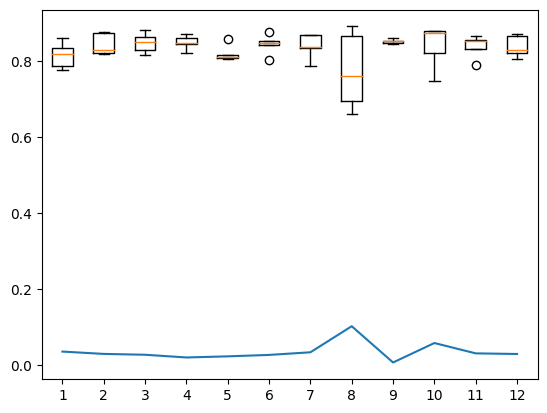

In [ ]:
plt.boxplot(df[df.columns]);
plt.plot([i for i in range(1, len(df.columns) + 1)], df.describe().transpose()["std"]);

We will show its mean and standar deviation too.

In [ ]:
df.describe().transpose()[["mean", "std"]]

,mean,std
11True,0.814779,0.034821
11False,0.843552,0.028620
1-1True,0.847993,0.026456
1-1False,0.848335,0.019267
31True,0.819327,0.022224
31False,0.844449,0.025997
3-1True,0.838696,0.032906
3-1False,0.774491,0.101540
51True,0.851203,0.006089
51False,0.839445,0.057333


We save the results in order to plot them together.

In [ ]:
folds = [["CM" + r[0], *r[1]] for r in results.items()]
df = pd.read_csv("SSA_testing.csv")
_df = pd.DataFrame(folds, columns = df.columns)
df = pd.concat([df, _df])
df.to_csv("SSA_testing.csv", index = False)

Finally, we can plot an example of inference.

In [ ]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
               get_items = get_image_files,
               get_y = get_y_fn,
               splitter = FuncSplitter(lambda x: Path(x).parent.name == "train"),
               item_tfms = [Resize((480,640)), TargetMaskConvertTransform()],
               batch_tfms = Normalize.from_stats(*imagenet_stats)
              )

dls = db.dataloaders(path_images, bs = 4)
learner = unet_learner(dls, **learner_hparams).to_fp16()
learner = learner.load("CarveMix")

mask = learner.predict(dls.train_ds[6][0])
print(np.unique(mask[0]))
mask = PILImage.create(decodes(mask[0]))

[0 1 2 3 4]


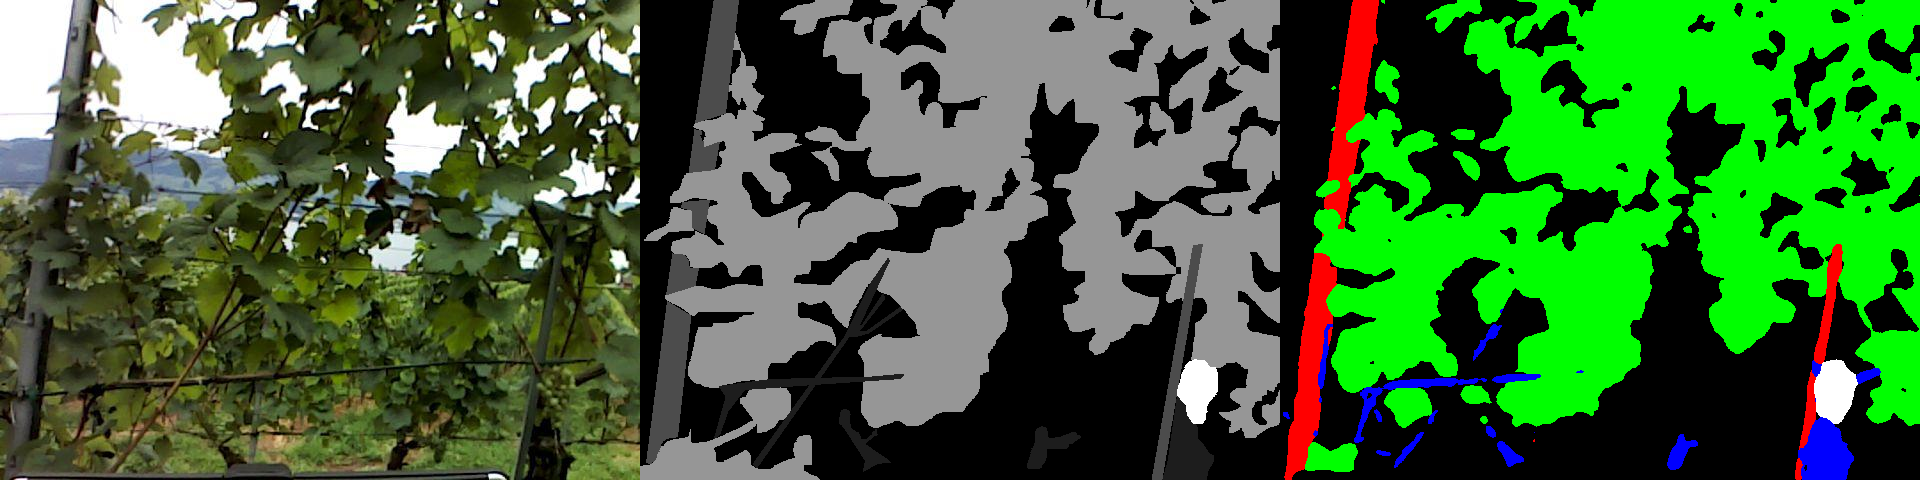

In [ ]:
image_grid([dls.train_ds[6][0], dls.train_ds[6][1], mask], rows = 1, cols = 3)

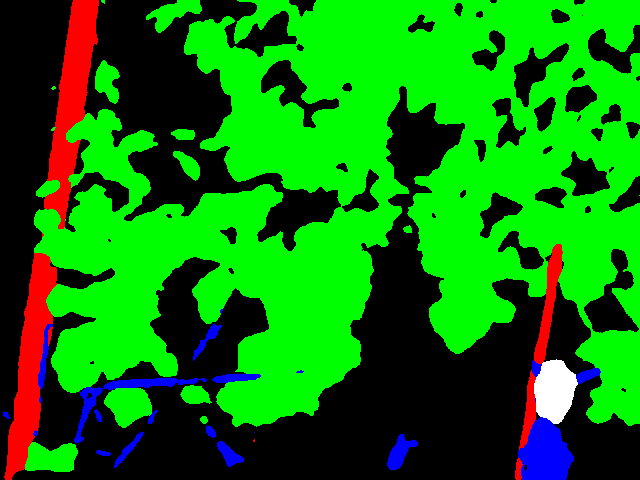

In [ ]:
mask